# Computational Thermofluid Dynamics - Chapter 3

Technical University of Munich, Professur für Thermofluiddynamik - Pr. Polifke

Created: 04/2024 | J. Yao, N. Garcia, G. Varillon

==============================================================================================

# Initialization
Initialize all the geometric and physical parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
def index(i, j, n):
    # Return the index in the computational vector based on the physical indices 'i' and 'j'
    return j+i*(n)


class Coordinate2D():
    def __init__(self, x, y):
        self.x = x
        self.y = y


def calculate_area(ul: Coordinate2D, bl: Coordinate2D, br: Coordinate2D, ur: Coordinate2D):
    # calculate the area of the cell
    # ul (upper left), bl (bottom left), br (bottom right), ur (upper right) are the coordinates of the four vertices of the cell
    # apply Gaussian trapezoidal formula to calculate the areas
    return 0.5 * abs( (ur.x*br.y - br.x*ur.y) + (br.x*bl.y - bl.x*br.y)
                     + (bl.x*ul.y - ul.x*bl.y) + (ul.x*ur.y - ur.x*ul.y) )


def dy(a: Coordinate2D, b: Coordinate2D):
    # Calculate distance between 'a' and 'b' along the y axis
    return b.y - a.y

def dx(a: Coordinate2D, b: Coordinate2D):
    # Calculate distance between 'a' and 'b' along the x axis
    return b.x - a.x


def dist(a: Coordinate2D, b: Coordinate2D):
    # Calculate the euclidean distance between 'a' and 'b'
    return ( (a.x - b.x)**2 + (a.y - b.y)**2 )**0.5



#############################################################################
def formfunction(x, shape: str):
    h1 = 4
    hm = 4
    h2 = 2

    if shape == 'linear':
        return (1-x)*h1/2 + x*h2/2
    
    elif shape == 'quadratic':
        c1 = h2+2*h1/2-2*hm
        c2 = 2*hm - 3*h1/2 - h2/2
        c3 = h1/2
        return c1*x**2 +c2*x + c3
    
    elif shape == 'crazy':
        d1 = 3
        d2 = 4
        return (1-x)*h1/2 + x*h2/2+ np.dot((np.sin(2*np.pi*d1*x)),(1-(1-1/d2)*x))
    
    else:
        raise ValueError('Unknown shape: %s' % shape)

def setUpMesh(n, shape: str, formfunction = formfunction):
    if (shape == 'linear'):
        x = np.linspace(0, 10, n)
        y_elevation = np.linspace(5, 1.5, n)
        Y = np.linspace(-y_elevation, y_elevation, n)
        X = np.tile(x, (n, 1))
        return X, Y
    elif (shape == 'rectangular'):
        x = np.linspace(0, 10, n)
        y = np.linspace(5, 1.5, n)
        X, Y = np.meshgrid(x, y)
        return X, Y
    

In [3]:
import numpy as np
from ex3_basics import index, Coordinate2D, calculate_area, dx, dy, dist


###############################################################################
class SteadyHeat2D_FVM():
    def __init__(self, X, Y, boundary=[], TD=[], q=10.0, alpha=5.0, Tinf=90.0):
        # i, j is the index of the cell
        # X, Y is the mesh
        # boundary is the boundary condition: 'TD', 'q', 'alpha', 'Tinf'
        # TD is the temperature difference
        # q is the heat flux
        # alpha is the heat transfer coefficient
        # Tinf is the temperature of the surrounding

        # self.i = i
        # self.j = j
        self.X = X
        self.Y = Y
        self.boundary = boundary
        self.TD = TD
        self.q = q
        self.alpha = alpha
        self.Tinf = Tinf

        # n is the number of points in the first direction
        # m is the number of points in the second direction
        self.n = self.X.shape[1]
        self.m = self.X.shape[0]

        self.A = np.zeros((self.n*self.m, self.n*self.m))
        self.B = np.zeros(self.n*self.m)
        self.T0 = np.zeros(self.n*self.m)
        

    def set_stencil(self, i, j):
        # Based on 'i','j' decide if the node is inner or boundary (which boundary?)
        a = 0
        b = 0
        if (j == 0):
            if (i == 0):
                a,b = self.build_NE(i,j)
            elif (i == self.n-1):
                a,b = self.build_SE(i,j)
            else:
                a,b = self.build_east(i,j)
        elif (j == self.n-1):
            if (i == 0):
                a,b = self.build_NW(i,j)
            elif (i == self.n-1):
                a,b = self.build_SW(i,j)
            else:
                a,b = self.build_west(i,j)
        elif (i == 0):
            a,b = self.build_north(i,j)
        elif (i == self.n-1):
            a,b = self.build_south(i,j)            
        else:
            a,b = self.build_inner(i,j)
        self.A[index(i,j,self.n)] += a
        self.B[index(i,j,self.n)] += b

    
    def build_inner(self, i, j):
        stencil = np.zeros(self.n*self.m)
        b = 0
        # % Nomenclature:
        # %
        # %    NW(i-1,j-1)   Nw -  N(i-1,j) -  Ne     NE(i-1,j+1)
        # %
        # %                 |                 |
        # %
        # %       nW - - - - nw ------ n ------ ne - - - nE
        # %                 |                 |
        # %       |         |        |        |       |
        # %                 |                 |
        # %   W(i, j-1) - - w - - P (i,j) - - e - -  E (i,j+1)
        # %                 |                 |
        # %       |         |        |        |       |
        # %                 |                 |
        # %      sW - - - - sw ------ s ------ se - - - sE
        # %
        # %                 |                 |
        # %
        # %   SW(i+1,j-1)   Sw  -  S(i+1,j)  - Se      SE(i+1,j+1)
        # %
        # % Indexing of stencil: 

        # %    D_4 - D_1 - D2
        # %     |     |     | 
        # %    D_3 - D_0 - D3
        # %     |     |     | 
        # %    D_2 -  D1 - D4

        # principle node coordinate
        P = Coordinate2D(self.X[i, j], self.Y[i, j])
        N = Coordinate2D(self.X[i-1, j], self.Y[i-1, j])
        S = Coordinate2D(self.X[i+1, j], self.Y[i+1, j])
        W = Coordinate2D(self.X[i, j-1], self.Y[i, j-1])
        E = Coordinate2D(self.X[i, j+1], self.Y[i, j+1])
        NW = Coordinate2D(self.X[i-1, j-1], self.Y[i-1, j-1])
        NE = Coordinate2D(self.X[i-1, j+1], self.Y[i-1, j+1])
        SW = Coordinate2D(self.X[i+1, j-1], self.Y[i+1, j-1])
        SE = Coordinate2D(self.X[i+1, j+1], self.Y[i+1, j+1])

        # auxiliary node coordinate
        Nw = Coordinate2D((N.x + NW.x)/2, (N.y + NW.y)/2)
        Ne = Coordinate2D((N.x + NE.x)/2, (N.y + NE.y)/2)
        Sw = Coordinate2D((S.x + SW.x)/2, (S.y + SW.y)/2)
        Se = Coordinate2D((S.x + SE.x)/2, (S.y + SE.y)/2)
        nW = Coordinate2D((W.x + NW.x)/2, (W.y + NW.y)/2)
        nE = Coordinate2D((E.x + NE.x)/2, (E.y + NE.y)/2)
        sW = Coordinate2D((W.x + SW.x)/2, (W.y + SW.y)/2)
        sE = Coordinate2D((E.x + SE.x)/2, (E.y + SE.y)/2)

        n = Coordinate2D((N.x + P.x)/2, (N.y + P.y)/2)
        s = Coordinate2D((S.x + P.x)/2, (S.y + P.y)/2)
        w = Coordinate2D((W.x + P.x)/2, (W.y + P.y)/2)
        e = Coordinate2D((E.x + P.x)/2, (E.y + P.y)/2)

        se = Coordinate2D((Se.x + e.x)/2, (Se.y + e.y)/2)
        sw = Coordinate2D((Sw.x + w.x)/2, (Sw.y + w.y)/2)
        ne = Coordinate2D((Ne.x + e.x)/2, (Ne.y + e.y)/2)
        nw = Coordinate2D((Nw.x + w.x)/2, (Nw.y + w.y)/2)
        
        # calculate the area of the cell
        S_P = calculate_area(ne, se, sw, nw)
        S_n = calculate_area(Ne, e, w, Nw)
        S_s = calculate_area(e, Se, Sw, w)
        S_w = calculate_area(n, s, sW, nW)
        S_e = calculate_area(nE, sE, s, n)

        D3 = ((dx(se, ne) * (dx(nE, n)/4 + dx(s, sE)/4 + dx(sE, nE))) / S_e + 
             (dy(se, ne) * (dy(nE, n)/4 + dy(s, sE)/4 + dy(sE, nE))) / S_e + 
             (dx(e, Ne) * dx(ne, nw)) / (4*S_n) + (dx(Se,e) * dx(sw,se)) / (4*S_s) + 
             (dy(e, Ne) * dy(ne, nw)) / (4*S_n) + (dy(Se,e) * dy(sw,se)) / (4*S_s)) / S_P
        D_3 = ((dx(nw, sw) * (dx(n, nW) / 4 + dx(sW, s) / 4 + dx(nW, sW))) / S_w +
              (dy(nw, sw) * (dy(n, nW) / 4 + dy(sW, s) / 4 + dy(nW, sW))) / S_w +
              (dx(Nw, w) * dx(ne, nw)) / (4 * S_n) +
              (dx(w, Sw) * dx(sw, se)) / (4 * S_s) +
              (dy(Nw, w) * dy(ne, nw)) / (4 * S_n) +
              (dy(w, Sw) * dy(sw, se)) / (4 * S_s)) / S_P
        D1 = ((dx(sw, se) * (dx(Se, e) / 4 + dx(w, Sw) / 4 + dx(Sw, Se))) / S_s +
            (dy(sw, se) * (dy(Se, e) / 4 + dy(w, Sw) / 4 + dy(Sw, Se))) / S_s +
            (dx(s, sE) * dx(se, ne)) / (4 * S_e) +
            (dx(sW, s) * dx(nw, sw)) / (4 * S_w) +
            (dy(s, sE) * dy(se, ne)) / (4 * S_e) +
            (dy(sW, s) * dy(nw, sw)) / (4 * S_w)) / S_P
        # North
        D_1 = ((dx(ne, nw) * (dx(e, Ne) / 4 + dx(Nw, w) / 4 + dx(Ne, Nw))) / S_n +
            (dy(ne, nw) * (dy(e, Ne) / 4 + dy(Nw, w) / 4 + dy(Ne, Nw))) / S_n +
            (dx(nE, n) * dx(se, ne)) / (4 * S_e) +
            (dx(n, nW) * dx(nw, sw)) / (4 * S_w) +
            (dy(nE, n) * dy(se, ne)) / (4 * S_e) +
            (dy(n, nW) * dy(nw, sw)) / (4 * S_w)) / S_P

        # NW
        D_4 = ((dx(Nw, w) * dx(ne, nw)) / (4 * S_n) +
            (dx(n, nW) * dx(nw, sw)) / (4 * S_w) +
            (dy(Nw, w) * dy(ne, nw)) / (4 * S_n) +
            (dy(n, nW) * dy(nw, sw)) / (4 * S_w)) / S_P

        # NE
        D2 = ((dx(nE, n) * dx(se, ne)) / (4 * S_e) +
            (dx(e, Ne) * dx(ne, nw)) / (4 * S_n) +
            (dy(nE, n) * dy(se, ne)) / (4 * S_e) +
            (dy(e, Ne) * dy(ne, nw)) / (4 * S_n)) / S_P

        # SW
        D_2 = ((dx(w, Sw) * dx(sw, se)) / (4 * S_s) +
            (dx(sW, s) * dx(nw, sw)) / (4 * S_w) +
            (dy(w, Sw) * dy(sw, se)) / (4 * S_s) +
            (dy(sW, s) * dy(nw, sw)) / (4 * S_w)) / S_P

        # SE
        D4 = ((dx(s, sE) * dx(se, ne)) / (4 * S_e) +
            (dx(Se, e) * dx(sw, se)) / (4 * S_s) +
            (dy(s, sE) * dy(se, ne)) / (4 * S_e) +
            (dy(Se, e) * dy(sw, se)) / (4 * S_s)) / S_P

        # Center (P)
        D0 = ((dx(se, ne) * (dx(n, s) + dx(nE, n) / 4 + dx(s, sE) / 4)) / S_e +
            (dx(ne, nw) * (dx(w, e) + dx(e, Ne) / 4 + dx(Nw, w) / 4)) / S_n +
            (dx(sw, se) * (dx(e, w) + dx(Se, e) / 4 + dx(w, Sw) / 4)) / S_s +
            (dx(nw, sw) * (dx(s, n) + dx(n, nW) / 4 + dx(sW, s) / 4)) / S_w +
            (dy(se, ne) * (dy(n, s) + dy(nE, n) / 4 + dy(s, sE) / 4)) / S_e +
            (dy(ne, nw) * (dy(w, e) + dy(e, Ne) / 4 + dy(Nw, w) / 4)) / S_n +
            (dy(sw, se) * (dy(e, w) + dy(Se, e) / 4 + dy(w, Sw) / 4)) / S_s +
            (dy(nw, sw) * (dy(s, n) + dy(n, nW) / 4 + dy(sW, s) / 4)) / S_w) / S_P
        
        stencil[index(i, j, self.n)] = D0
        stencil[index(i-1, j, self.n)] = D_1
        stencil[index(i+1, j, self.n)] = D1
        stencil[index(i, j-1, self.n)] = D_3
        stencil[index(i, j+1, self.n)] = D3
        stencil[index(i-1, j-1, self.n)] = D_4
        stencil[index(i-1, j+1, self.n)] = D2
        stencil[index(i+1, j-1, self.n)] = D_2
        stencil[index(i+1, j+1, self.n)] = D4
        
        return stencil,b
    
######################################################################################################################################
    def build_north(self, i, j):
        stencil = np.zeros(self.n*self.m)
        b = 0
        if self.boundary[0] == 'D':
            stencil[index(i, j, self.n)] = 1.0
            b = self.TD[0]
        else: 
            # principle node coordinate
            P = Coordinate2D(self.X[i, j], self.Y[i, j])
            S = Coordinate2D(self.X[i+1, j], self.Y[i+1, j])
            W = Coordinate2D(self.X[i, j-1], self.Y[i, j-1])
            E = Coordinate2D(self.X[i, j+1], self.Y[i, j+1])
            SW = Coordinate2D(self.X[i+1, j-1], self.Y[i+1, j-1])
            SE = Coordinate2D(self.X[i+1, j+1], self.Y[i+1, j+1])

            # auxiliary node coordinate
            Sw = Coordinate2D((S.x + SW.x)/2, (S.y + SW.y)/2)
            Se = Coordinate2D((S.x + SE.x)/2, (S.y + SE.y)/2)
            sW = Coordinate2D((W.x + SW.x)/2, (W.y + SW.y)/2)
            sE = Coordinate2D((E.x + SE.x)/2, (E.y + SE.y)/2)

            s = Coordinate2D((S.x + P.x)/2, (S.y + P.y)/2)
            w = Coordinate2D((W.x + P.x)/2, (W.y + P.y)/2)
            e = Coordinate2D((E.x + P.x)/2, (E.y + P.y)/2)

            se = Coordinate2D((Se.x + e.x)/2, (Se.y + e.y)/2)
            sw = Coordinate2D((Sw.x + w.x)/2, (Sw.y + w.y)/2)

            # calculate the area of the cell
            S_ss = calculate_area(e, se, sw, w)
            S_s = calculate_area(e, Se, Sw, w)
            S_ssw = calculate_area(P, s, sW, W)
            S_sse = calculate_area(E, sE, s, P)

            # East
            D3 = (dy(sw, se) * (dy(Se, e) / 4) / S_s + dx(sw, se) * (dx(Se, e) / 4) / S_s +
                dy(se, e) * (dy(s, sE) / 4 + 3 * dy(sE, E) / 4 + dy(E, P) / 2) / S_sse +
                dx(se, e) * (dx(s, sE) / 4 + 3 * dx(sE, E) / 4 + dx(E, P) / 2) / S_sse) / S_ss

            # West
            D_3 = (dy(w, sw) * (3 * dy(W, sW) / 4 + dy(sW, s) / 4 + dy(P, W) / 2) / S_ssw +
                dx(w, sw) * (3 * dx(W, sW) / 4 + dx(sW, s) / 4 + dx(P, W) / 2) / S_ssw +
                dy(sw, se) * (dy(w, Sw) / 4) / S_s + dx(sw, se) * (dx(w, Sw) / 4) / S_s) / S_ss

            # South
            D1 = (dy(w, sw) * (dy(sW, s) / 4 + dy(s, P) / 4) / S_ssw +
                dx(w, sw) * (dx(sW, s) / 4 + dx(s, P) / 4) / S_ssw +
                dy(sw, se) * (dy(w, Sw) / 4 + dy(Sw, Se) + dy(Se, e) / 4) / S_s +
                dx(sw, se) * (dx(w, Sw) / 4 + dx(Sw, Se) + dx(Se, e) / 4) / S_s +
                dy(se, e) * (dy(P, s) / 4 + dy(s, sE) / 4) / S_sse +
                dx(se, e) * (dx(P, s) / 4 + dx(s, sE) / 4) / S_sse) / S_ss

            # SW
            D_2 = (dy(w, sw) * (dy(W, sW) / 4 + dy(sW, s) / 4) / S_ssw +
                dx(w, sw) * (dx(W, sW) / 4 + dx(sW, s) / 4) / S_ssw +
                dy(sw, se) * (dy(w, Sw) / 4) / S_s + dx(sw, se) * (dx(w, Sw) / 4) / S_s) / S_ss

            # SE
            D4 = (dy(sw, se) * (dy(Se, e) / 4) / S_s + dx(sw, se) * (dx(Se, e) / 4) / S_s +
                dy(se, e) * (dy(s, sE) / 4 + dy(sE, E) / 4) / S_sse +
                dx(se, e) * (dx(s, sE) / 4 + dx(sE, E) / 4) / S_sse) / S_ss
            
            coefficient = 0.0
            if self.boundary[0] == 'N':
                coefficient = 0.0
                b = self.q * dist(e, w) / S_ss
            elif self.boundary[0] == 'R':
                coefficient = - self.alpha
                b = - self.alpha * self.Tinf * dist(e, w) / S_ss
            else:
                raise ValueError('Unknown boundary type: %s' % self.boundary[0])
            
            D0 = (coefficient * dist(e, w) +
                dy(w, sw) * (dy(sW, s) / 4 + 3 * dy(s, P) / 4 + dy(P, W) / 2) / S_ssw +
                dx(w, sw) * (dx(sW, s) / 4 + 3 * dx(s, P) / 4 + dx(P, W) / 2) / S_ssw +
                dy(sw, se) * (dy(w, Sw) / 4 + dy(Se, e) / 4 + dy(e, w)) / S_s +
                dx(sw, se) * (dx(w, Sw) / 4 + dx(Se, e) / 4 + dx(e, w)) / S_s +
                dy(se, e) * (3 * dy(P, s) / 4 + dy(s, sE) / 4 + dy(E, P) / 2) / S_sse +
                dx(se, e) * (3 * dx(P, s) / 4 + dx(s, sE) / 4 + dx(E, P) / 2) / S_sse) / S_ss
            
            stencil[index(i, j, self.n)] = D0
            stencil[index(i+1, j, self.n)] = D1
            stencil[index(i, j-1, self.n)] = D_3
            stencil[index(i, j+1, self.n)] = D3
            stencil[index(i+1, j-1, self.n)] = D_2
            stencil[index(i+1, j+1, self.n)] = D4

        return stencil,b

######################################################################################################################################
    def build_south(self, i, j):
        stencil = np.zeros(self.n*self.m)
        b = np.zeros(1)
        if self.boundary[2] == 'D':
            stencil[index(i, j, self.n)] = 1.0
            b = self.TD[2]
        else: 
            # principle node coordinate
            P = Coordinate2D(self.X[i, j], self.Y[i, j])
            N = Coordinate2D(self.X[i-1, j], self.Y[i-1, j])
            W = Coordinate2D(self.X[i, j-1], self.Y[i, j-1])
            E = Coordinate2D(self.X[i, j+1], self.Y[i, j+1])
            NW = Coordinate2D(self.X[i-1, j-1], self.Y[i-1, j-1])
            NE = Coordinate2D(self.X[i-1, j+1], self.Y[i-1, j+1])

            # auxiliary node coordinate
            Nw = Coordinate2D((N.x + NW.x)/2, (N.y + NW.y)/2)
            Ne = Coordinate2D((N.x + NE.x)/2, (N.y + NE.y)/2)
            nW = Coordinate2D((W.x + NW.x)/2, (W.y + NW.y)/2)
            nE = Coordinate2D((E.x + NE.x)/2, (E.y + NE.y)/2)

            n = Coordinate2D((N.x + P.x)/2, (N.y + P.y)/2)
            w = Coordinate2D((W.x + P.x)/2, (W.y + P.y)/2)
            e = Coordinate2D((E.x + P.x)/2, (E.y + P.y)/2)

            ne = Coordinate2D((Ne.x + e.x)/2, (Ne.y + e.y)/2)
            nw = Coordinate2D((Nw.x + w.x)/2, (Nw.y + w.y)/2)

            # calculate the area of the cell
            S_nn = calculate_area(ne, e, w, nw)
            S_n = calculate_area(Ne, e, w, Nw)
            S_nnw = calculate_area(n, P, W, nW)
            S_nne = calculate_area(nE, E, P, n)


            # East
            D3 = (dy(ne, nw) * (dy(e, Ne) / 4) / S_n + dx(ne, nw) * (dx(e, Ne) / 4) / S_n +
                dy(e, ne) * (dy(nE, n) / 4 + 3 * dy(E, nE) / 4 + dy(P, E) / 2) / S_nne +
                dx(e, ne) * (dx(nE, n) / 4 + 3 * dx(E, nE) / 4 + dx(P, E) / 2) / S_nne) / S_nn

            # West
            D_3 = (dy(nw, w) * (3 * dy(nW, W) / 4 + dy(n, nW) / 4 + dy(W, P) / 2) / S_nnw +
                dx(nw, w) * (3 * dx(nW, W) / 4 + dx(n, nW) / 4 + dx(W, P) / 2) / S_nnw +
                dy(ne, nw) * (dy(Nw, w) / 4) / S_n + dx(ne, nw) * (dx(Nw, w) / 4) / S_n) / S_nn

            # North
            D_1 = (dy(nw, w) * (dy(n, nW) / 4 + dy(P, n) / 4) / S_nnw +
                dx(nw, w) * (dx(n, nW) / 4 + dx(P, n) / 4) / S_nnw +
                dy(ne, nw) * (dy(Nw, w) / 4 + dy(Ne, Nw) + dy(e, Ne) / 4) / S_n +
                dx(ne, nw) * (dx(Nw, w) / 4 + dx(Ne, Nw) + dx(e, Ne) / 4) / S_n +
                dy(e, ne) * (dy(n, P) / 4 + dy(nE, n) / 4) / S_nne +
                dx(e, ne) * (dx(n, P) / 4 + dx(nE, n) / 4) / S_nne) / S_nn

            # NE
            D2 = (dy(ne, nw) * (dy(e, Ne) / 4) / S_n + dx(ne, nw) * (dx(e, Ne) / 4) / S_n +
                dy(e, ne) * (dy(nE, n) / 4 + dy(E, nE) / 4) / S_nne +
                dx(e, ne) * (dx(nE, n) / 4 + dx(E, nE) / 4) / S_nne) / S_nn
            

            # NW
            D_4 = (dy(nw, w) * (dy(nW, W) / 4 + dy(n, nW) / 4) / S_nnw +
                dx(nw, w) * (dx(nW, W) / 4 + dx(n, nW) / 4) / S_nnw +
                dy(ne, nw) * (dy(Nw, w) / 4) / S_n + dx(ne, nw) * (dx(Nw, w) / 4) / S_n) / S_nn 
            
            coefficient = 0.0
            if self.boundary[2] == 'N':
                coefficient = 0.0
                b = self.q * (dist(e, w)) / S_nn
            elif self.boundary[2] == 'R':
                coefficient = - self.alpha
                b = - self.alpha * self.Tinf * (dist(e, w)) / S_nn
            else:
                raise ValueError('Unknown boundary type: %s' % self.boundary[2])
            
            D0 = (coefficient * dist(e, w) +
                dy(nw, w) * (dy(n, nW) / 4 + 3 * dy(P ,n) / 4 + dy(W, P) / 2) / S_nnw +
                dx(nw, w) * (dx(n, nW) / 4 + 3 * dx(P, n) / 4 + dx(W, P) / 2) / S_nnw +
                dy(ne, nw) * (dy(Nw, w) / 4 + dy(e, Ne) / 4 + dy(w, e)) / S_n +
                dx(ne, nw) * (dx(Nw, w) / 4 + dx(e, Ne) / 4 + dx(w, e)) / S_n +
                dy(e, ne) * (3 * dy(n, P) / 4 + dy(nE, n) / 4 + dy(P, E) / 2) / S_nne +
                dx(e, ne) * (3 * dx(n, P) / 4 + dx(nE, n) / 4 + dx(P, E) / 2) / S_nne) / S_nn
            
            # print("this is the south [" + str(i) +"][" + str(j) + "]: " + str(D0) + ", " + str(D_1) + ", " + str(D_3) + ", " + str(D3) + ", " + str(D2) + ", " + str(D_4))
            
            stencil[index(i, j, self.n)] = D0
            stencil[index(i-1, j, self.n)] = D_1
            stencil[index(i, j-1, self.n)] = D_3
            stencil[index(i, j+1, self.n)] = D3
            stencil[index(i-1, j+1, self.n)] = D2
            stencil[index(i-1, j-1, self.n)] = D_4

        return stencil,b

######################################################################################################################################
    def build_east(self, i, j):
        stencil = np.zeros(self.n*self.m)
        b = 0
        if self.boundary[1] == 'D':
            stencil[index(i, j, self.n)] = 1.0
            b = self.TD[1]
        else: 
            # principle node coordinate
            P = Coordinate2D(self.X[i, j], self.Y[i, j])
            S = Coordinate2D(self.X[i+1, j], self.Y[i+1, j])
            W = Coordinate2D(self.X[i, j-1], self.Y[i, j-1])
            N = Coordinate2D(self.X[i-1, j], self.Y[i-1, j])
            NW = Coordinate2D(self.X[i-1, j-1], self.Y[i-1, j-1])
            SW = Coordinate2D(self.X[i+1, j-1], self.Y[i+1, j-1])

            # auxiliary node coordinate
            Sw = Coordinate2D((S.x + SW.x)/2, (S.y + SW.y)/2)
            Nw = Coordinate2D((N.x + NW.x)/2, (N.y + NW.y)/2)
            sW = Coordinate2D((W.x + SW.x)/2, (W.y + SW.y)/2)
            nW = Coordinate2D((W.x + NW.x)/2, (W.y + NW.y)/2)

            w = Coordinate2D((W.x + P.x)/2, (W.y + P.y)/2)
            n = Coordinate2D((N.x + P.x)/2, (N.y + P.y)/2)
            s = Coordinate2D((S.x + P.x)/2, (S.y + P.y)/2)

            nw = Coordinate2D((NW.x + P.x)/2, (NW.y + P.y)/2)
            sw = Coordinate2D((SW.x + P.x)/2, (SW.y + P.y)/2)

            # calculate the area of the cell
            S_ww = calculate_area(n, s, sw, nw)
            S_w = calculate_area(n, s, sW, nW)
            S_wwn = calculate_area(N, P, w, Nw)
            S_wws = calculate_area(P, S, Sw, w)


            # East -> South
            D3 = (dy(nw, sw) * (dy(sW, s) / 4) / S_w + dx(nw, sw) * (dx(sW, s) / 4) / S_w +
                dy(sw, s) * (dy(w, Sw) / 4 + 3 * dy(Sw, S) / 4 + dy(S, P) / 2) / S_wws +
                dx(sw, s) * (dx(w, Sw) / 4 + 3 * dx(Sw, S) / 4 + dx(S, P) / 2) / S_wws) / S_ww

            # West -> North
            D_3 = (dy(n, nw) * (3 * dy(N, Nw) / 4 + dy(Nw, w) / 4 + dy(P, N) / 2) / S_wwn +
                dx(n, nw) * (3 * dx(N, Nw) / 4 + dx(Nw, w) / 4 + dx(P, N) / 2) / S_wwn +
                dy(nw, sw) * (dy(n, nW) / 4) / S_w + dx(nw, sw) * (dx(n, nW) / 4) / S_w) / S_ww

            # South -> West
            D1 = (dy(n, nw) * (dy(Nw, w) / 4 + dy(w, P) / 4) / S_wwn +
                dx(n, nw) * (dx(Nw, w) / 4 + dx(w, P) / 4) / S_wwn +
                dy(nw, sw) * (dy(n, nW) / 4 + dy(nW, sW) + dy(sW, s) / 4) / S_w +
                dx(nw, sw) * (dx(n, nW) / 4 + dx(nW, sW) + dx(sW, s) / 4) / S_w +
                dy(sw, s) * (dy(P, w) / 4 + dy(w, Sw) / 4) / S_wws +
                dx(sw, s) * (dx(P, w) / 4 + dx(w, Sw) / 4) / S_wws) / S_ww

            # SW ->NW
            D_2 = (dy(n, nw) * (dy(N, Nw) / 4 + dy(Nw, w) / 4) / S_wwn +
                dx(n, nw) * (dx(N, Nw) / 4 + dx(Nw, w) / 4) / S_wwn +
                dy(nw, sw) * (dy(n, nW) / 4) / S_w + dx(nw, sw) * (dx(n, nW) / 4) / S_w) / S_ww
            
            # SE -> SW
            D4 = (dy(nw, sw) * (dy(sW, s) / 4) / S_w + dx(nw, sw) * (dx(sW, s) / 4) / S_w +
                dy(sw, s) * (dy(w, Sw) / 4 + dy(Sw, S) / 4) / S_wws +
                dx(sw, s) * (dx(w, Sw) / 4 + dx(Sw, S) / 4) / S_wws) / S_ww
            
            coefficient = 0.0
            if self.boundary[1] == 'N':
                coefficient = 0.0
                b = self.q * dist(s, n) / S_ww
            elif self.boundary[1] == 'R':
                coefficient = - self.alpha
                b = - self.alpha * self.Tinf * dist(n, s) / S_ww
            else:
                raise ValueError('Unknown boundary type: %s' % self.boundary[1])
            
            # check this again later
            D0 = (coefficient * dist(s, n) +
                dy(n, nw) * (dy(Nw, w) / 4 + 3 * dy(w, P) / 4 + dy(P, N) / 2) / S_wwn +
                dx(n, nw) * (dx(Nw, w) / 4 + 3 * dx(w, P) / 4 + dx(P, N) / 2) / S_wwn +
                dy(nw, sw) * (dy(n, nW) / 4 + dy(sW, s) / 4 + dy(s, n)) / S_w +
                dx(nw, sw) * (dx(n, nW) / 4 + dx(sW, s) / 4 + dx(s, n)) / S_w +
                dy(sw, s) * (3 * dy(P, w) / 4 + dy(w, Sw) / 4 + dy(S, P) / 2) / S_wws +
                dx(sw, s) * (3 * dx(P, w) / 4 + dx(w, Sw) / 4 + dx(S, P) / 2) / S_wws) / S_ww
          
            stencil[index(i, j, self.n)] = D0
            stencil[index(i, j-1, self.n)] = D1 #west
            stencil[index(i-1, j, self.n)] = D_3 #north
            stencil[index(i+1, j, self.n)] = D3 #south
            stencil[index(i-1, j-1, self.n)] = D_2 #nw
            stencil[index(i+1, j-1, self.n)] = D4 #sw

        return stencil,b
            
    def build_west(self, i, j):
        stencil = np.zeros(self.n*self.m)
        b = np.zeros(1)
        # if self.boundary[3] == 'D':
        stencil[index(i, j, self.n)] = 1.0
        b = self.TD[3]
        return stencil,b
    
    def build_NW(self, i, j):
        stencil = np.zeros(self.n*self.m)
        b = np.zeros(1)
        # if self.boundary[1] == 'D':
        stencil[index(i, j, self.n)] = 1.0
        b = self.TD[3]
        return stencil,b
        
    
    def build_NE(self, i, j):
        stencil = np.zeros(self.n*self.m)
        b = np.zeros(1)
        if self.boundary[1] == 'D':
            stencil[index(i, j, self.n)] = 1.0
            b = self.TD[1]
        else:
            # principle node coordinate
            P = Coordinate2D(self.X[i, j], self.Y[i, j])
            S = Coordinate2D(self.X[i+1, j], self.Y[i+1, j])
            W = Coordinate2D(self.X[i, j-1], self.Y[i, j-1])
            SW = Coordinate2D(self.X[i+1, j-1], self.Y[i+1, j-1])

            # auxiliary node coordinate
            Sw = Coordinate2D((S.x + SW.x)/2, (S.y + SW.y)/2)
            sW = Coordinate2D((W.x + SW.x)/2, (W.y + SW.y)/2)

            s = Coordinate2D((S.x + P.x)/2, (S.y + P.y)/2)
            w = Coordinate2D((W.x + P.x)/2, (W.y + P.y)/2)

            sw = Coordinate2D((Sw.x + w.x)/2, (Sw.y + w.y)/2)
            sigma = Coordinate2D((s.x + P.x)/2, (s.y + P.y)/2)
            omega = Coordinate2D((w.x + P.x)/2, (w.y  + P.y)/2)
            sigmaW = Coordinate2D((W.x + sW.x)/2, (W.y + sW.y)/2)
            Somega = Coordinate2D((S.x + Sw.x)/2 , (S.y + Sw.y)/2)
            sigma_w = Coordinate2D((sigma.x + sigmaW.x)/2, (sigma.y + sigmaW.y)/2)
            s_omega = Coordinate2D((omega.x + Somega.x)/2 , (omega.y + Somega.y)/2)
            sigmaomega = Coordinate2D((omega.x + s_omega.x)/2, (omega.y + s_omega.y)/2)
            
            #calculate areas
            S_sigmaomega = calculate_area(P, s, sw, w)
            S_sigmaS = calculate_area(P, S, Sw, w)
            S_sigmaW = calculate_area(P, s, sW, W)
            
            # South
            D1 = (dy(sw, s) * (3 * dy(Sw, S) / 4 + dy(S, P) / 2 + dy(w, Sw) / 4) / S_sigmaS +
                dx(sw, s) * (3 * dx(Sw, S) / 4 + dx(S, P) / 2 + dx(w, Sw) / 4) / S_sigmaS +
                dy(w, sw) * (dy(sW, s) / 4 + dy(s, P) / 4) / S_sigmaW +
                dx(w, sw) * (dx(sW, s) / 4 + dx(s, P) / 4) / S_sigmaW) / S_sigmaomega
            
            # West
            D_3 = (dy(sw, s) * (dy(P, w) / 4 + dy(w, Sw) / 4) / S_sigmaS +
                dx(sw, s) * (dx(P, w) / 4 + dx(w, Sw) / 4) / S_sigmaS +
                dy(w, sw) * (dy(sW, s) / 4 + dy(P, W) / 2 + 3 * dy(W, sW) / 4) / S_sigmaW +
                dx(w, sw) * (dx(sW, s) / 4 + dx(P, W) / 2 + 3 * dx(W, sW) / 4) / S_sigmaW) / S_sigmaomega
            
            #SW
            D_2 = (dy(sw, s) * (dy(Sw, S) / 4 + dy(w, Sw) / 4) / S_sigmaS +
                dx(sw, s) * (dx(Sw, S) / 4 + dx(w, Sw) / 4) / S_sigmaS +
                dy(w, sw) * (dy(sW, s) / 4 + dy(W, sW) / 4) / S_sigmaW +
                dx(w, sw) * (dx(sW, s) / 4 + dx(W, sW) / 4) / S_sigmaW) / S_sigmaomega 
            
            coefficient1 = 0.0
            coefficient2 = 0.0
            if self.boundary[1] == 'N': #east boundary
                coefficient1 = 0.0 
                b = self.q * (dist(s, P)) / S_sigmaomega
            elif self.boundary[1] == 'R':
                coefficient1 = - self.alpha
                b = - self.alpha * self.Tinf * (dist(s, P) + dist(P, w)) / S_sigmaomega
            if self.boundary[0] == 'N': #north boundary
                coefficient2 = 0.0
                b = self.q * (dist(P, w)) / S_sigmaomega
            elif self.boundary[0] == 'R':
                coefficient2 = - self.alpha
                b = - self.alpha * self.Tinf * (dist(P, w) + dist(s,P))/ S_sigmaomega
            else:
                raise ValueError('Unknown boundary type: %s' % self.boundary[2])
            
            D0 = (coefficient1 * dist(s, P) + coefficient2 * dist(P, w) +
                dy(sw, s) * (dy(S, P) / 2 + 3 * dy(P, w) / 4 + dy(w, Sw) / 4) / S_sigmaS +
                dx(sw, s) * (dx(S, P) / 2 + 3 * dx(P, w) / 4 + dx(w, Sw) / 4) / S_sigmaS +
                dy(w, sw) * (dy(sW, s) / 4 + 3 * dy(s, P) / 4 + dy(P, W) / 2) / S_sigmaW +
                dx(w, sw) * (dx(sW, s) / 4 + 3 * dx(s, P) / 4 + dx(P, W) / 2) / S_sigmaW) / S_sigmaomega
            
            stencil[index(i, j, self.n)] = D0
            stencil[index(i+1, j, self.n)] = D1 #south
            stencil[index(i, j-1, self.n)] = D_3 #west
            stencil[index(i+1, j-1, self.n)] = D_2 #sw
            
        return stencil,b
        
    def build_SW(self, i, j):
        stencil = np.zeros(self.n*self.m)
        b = np.zeros(1)
        # if self.boundary[1] == 'D':
        stencil[index(i, j, self.n)] = 1.0
        b = self.TD[3]
        return stencil,b
        
    def build_SE(self, i, j):
        stencil = np.zeros(self.n*self.m)
        b = np.zeros(1)
        if self.boundary[1] == 'D':
            stencil[index(i, j, self.n)] = 1.0
            b = self.TD[1]
        
        # this has to be thermally insulated since we are duplicating and mirroring the top
        else:
            # principle node coordinate
            P = Coordinate2D(self.X[i, j], self.Y[i, j])
            N = Coordinate2D(self.X[i-1, j], self.Y[i-1, j])
            W = Coordinate2D(self.X[i, j-1], self.Y[i, j-1])
            NW = Coordinate2D(self.X[i-1, j-1], self.Y[i-1, j-1])

            # auxiliary node coordinate
            Nw = Coordinate2D((N.x + NW.x)/2, (N.y + NW.y)/2)
            nW = Coordinate2D((W.x + NW.x)/2, (W.y + NW.y)/2)

            n = Coordinate2D((N.x + P.x)/2, (N.y + P.y)/2)
            w = Coordinate2D((W.x + P.x)/2, (W.y + P.y)/2)

            nw = Coordinate2D((Nw.x + w.x)/2, (Nw.y + w.y)/2)
            eta = Coordinate2D((n.x + P.x)/2, (n.y + P.y)/2)
            omega = Coordinate2D((w.x + P.x)/2, (w.y  + P.y)/2)
            nomega = Coordinate2D((nw.x + n.x)/2, (nw.y + n.y)/2)
            etaw = Coordinate2D((nw.x + w.x)/2, (nw.y + w.y)/2)
            etaomega = Coordinate2D((nomega.x + omega.x)/2, (nomega.y + omega.y)/2)

            Nomega = Coordinate2D((N.x + Nw.x)/2, (N.y + Nw.y)/2)
            etaW = Coordinate2D((nW.x + W.x)/2, (nW.y + W.y)/2)

            #calculate areas
            S_etaomega = calculate_area(n, P, w, nw)
            S_etaW = calculate_area(n, P, W, nW)
            S_etaN = calculate_area(N, P, w, Nw)

            #we will need D_3 and D_1 for the west and north respectively

            # North
            D_1 = (dy(n, nw) * (dy(P, N) / 2 + 3* dy(N, Nw) / 4 + dy(Nw, w) / 4) / S_etaN +
                dx(n, nw) * (dx(P, N) / 2 + 3* dx(N, Nw) / 4 + dx(Nw, w) / 4) / S_etaN +
                dy(nw, w) * (dy(P, n) / 4 + dy(n, nW) / 4) / S_etaW +
                dx(nw, w) * (dx(P, n) / 4 + dx(n, nW) / 4) / S_etaW) / S_etaomega

            # West
            D_3 = (dy(n, nw) * (dy(w, P) / 4  + dy(Nw, w) / 4) / S_etaN +
                dx(n, nw) * (dx(w, P) / 4  + dx(Nw, w) / 4) / S_etaN +
                dy(nw, w) * (dy(W, P) / 2 + dy(n, nW) / 4 + 3 * dy(nW, W) / 4) / S_etaW +
                dx(nw, w) * (dx(W, P) / 2 + dx(n, nW) / 4 + 3 * dx(nW, W) / 4) / S_etaW) / S_etaomega

            # NW
            D_4 = (dy(n, nw) * (dy(N, Nw) / 4  + dy(Nw, w) / 4) / S_etaN +
                dx(n, nw) * (dx(N, Nw) / 4  + dx(Nw, w) / 4) / S_etaN +
                dy(nw, w) * (dy(n, nW) / 4 + dy(nW, W) / 4) / S_etaW +
                dx(nw, w) * (dx(n, nW) / 4 + dx(nW, W) / 4) / S_etaW) / S_etaomega
            
            coefficient1 = 0.0
            coefficient2 = 0.0
            if self.boundary[1] == 'N': #east boundary
                coefficient1 = 0.0 
                b = 0.0
            elif self.boundary[1] == 'R':
                coefficient1 = 0.0
                b = 0.0
            if self.boundary[2] == 'N': #south boundary
                coefficient2 = 0.0
                b = 0.0
            elif self.boundary[2] == 'R':
                coefficient2 = 0.0
                b = 0.0
            else:
                raise ValueError('Unknown boundary type: %s' % self.boundary[2])
            
            D0 = (coefficient1 * dist(P, n) + coefficient2 * dist(w, P) +
                dy(n, nw) * (3 * dy(w, P) / 4 + dy(P, N) / 2 + dy(Nw, w) / 4) / S_etaN +
                dx(n, nw) * (3 * dx(w, P) / 4 + dx(P, N) / 2 + dx(Nw, w) / 4) / S_etaN +
                dy(nw, w) * (dy(W, P) / 2 + 3 * dy(P, n) / 4 + dy(n, nW)/ 4) / S_etaW +
                dx(nw, w) * (dx(W, P) / 2 + 3 * dx(P, n) / 4 + dx(n, nW)/ 4) / S_etaW) / S_etaomega
            
            print("help:" + str(D0))
                
            stencil[index(i, j, self.n)] = D0
            stencil[index(i-1, j, self.n)] = D_1 #north
            stencil[index(i, j-1, self.n)] = D_3 #west
            stencil[index(i-1, j-1, self.n)] = D_4 #NW
        
        return stencil,b
    

    def set_initial_temperature(self):
        if self.boundary[2] == 'D': #north
            for j in range(self.n):
                self.T0[index(0, j, self.n)] = self.TD[0]

        if self.boundary[0] == 'D': #south
            for j in range(self.n):
                self.T0[index(self.m-1, j, self.n)] = self.TD[2]

        if self.boundary[3] == 'D': #west
            for i in range(self.m):
                self.T0[index(i, 0, self.n)] = self.TD[3]

        if self.boundary[1] == 'D': #east
            for i in range(self.m):
                self.T0[index(i, self.m-1, self.n)] = self.TD[1]


        
    def solve(self, solution, dt = 0.01, t_end = 4.0, theta=0.5):
        for i in range(self.n):
                for j in range(self.m):
                    self.set_stencil(i,j)
        if solution == "steady":
            self.T0 = np.linalg.solve(self.A, self.B)
            return self.T0
        
        elif solution == "unsteady":
            t = 0
            while t < t_end:
                self.T0 = self.T0 + dt*(self.A@self.T0 - self.B)
                t += dt
            return self.T0
        
        elif solution == 'temporal':
            self.set_initial_temperature()
            t = 0
            Bstar = np.zeros(self.m*self.n)
            Imatrix = np.eye(self.m*self.n)
            Astar = Imatrix/dt - theta*self.A
            while t < t_end:
                Bstar = self.T0/dt + (1-theta) * self.A@self.T0 - self.B
                self.T0 = np.linalg.solve(Astar, Bstar)
                t += dt
            return self.T0
        
        elif solution == "unsteadyi":
            self.set_initial_temperature()
            t = 0
            Bstar = np.zeros(self.m*self.n)
            Imatrix = np.eye(self.m*self.n)
            Astar = Imatrix - dt*self.A
            while t < t_end:
                Bstar = self.T0 - dt*self.B
                # Astar = I - dt*self.A
                self.T0 = np.linalg.solve(Astar, Bstar)
                t += dt
            return self.T0

            # pass        
        else:
            raise ValueError("Mode must be either 'steady' or 'unsteady' ")
        
        

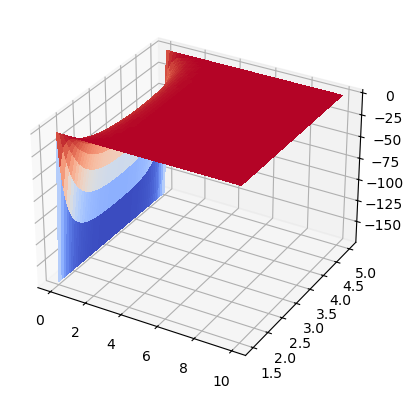

In [6]:
dim = 50

X, T = setUpMesh(n=dim, shape='rectangular')
dued = SteadyHeat2D_FVM(X, T, boundary=['D', 'D', 'D', 'D'], TD=[0, 0, 0, 100])

solution = dued.solve(solution='unsteady', dt=0.001, t_end=1) # using explicit scheme

matrix = solution.reshape((dim, dim))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, T, matrix, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.show()

In [5]:
dim = 50

X, T = setUpMesh(n=dim, shape='linear')
dued = SteadyHeat2D_FVM(X, T, boundary=['R', 'N', 'N', 'R'], TD=[0, 0, 0, 100])

solution = dued.solve(solution='unsteady', dt=0.001, t_end=1) # using explicit scheme

matrix = solution.reshape((dim, dim))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, T, matrix, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.show()

IndexError: index 50 is out of bounds for axis 0 with size 50

help:-527.7015833910308


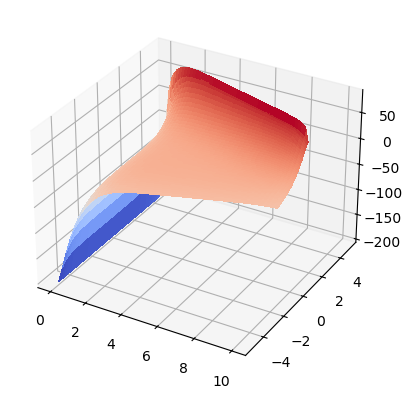

In [36]:
dim = 50

X, T = setUpMesh(n=dim, shape='linear')
dued = SteadyHeat2D_FVM(X, T, boundary=['N', 'N', 'R', 'R'], TD=[0, 0, 0, 100])

solution = dued.solve(solution='temporal', dt=0.1, t_end=1, theta=0.5) # using explicit scheme

matrix = solution.reshape((dim, dim))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, T, matrix, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.show()